In [1]:
import os
import json

In [2]:
import logging
logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.INFO)

In [ ]:
import umap
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from openai import OpenAI
from qdrant_client import QdrantClient
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

## Semantic Search

In [4]:
client = OpenAI()
qdrant = QdrantClient()

In [5]:
# query = "What is the price of a house with 3 bedrooms, 2 bathrooms, 1000 sqft land, and 800 sqft house?"
# query = "berapa harga rumah dengan 10 kamar tidur, 5 kamar mandi, 1000 meter persegi tanah, dan 800 meter persegi bangunan?"
query = "rekomendasi rumah dengan 3 kamar tidur"

query_embeddings = client.embeddings.create(input=[query], model="text-embedding-3-small")

INFO - httpx -  HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [6]:
documents = qdrant.search(collection_name="rumah_bogor", query_vector=query_embeddings.data[0].embedding, with_vectors=True, with_payload=True, limit=500)

INFO - httpx -  HTTP Request: POST http://localhost:6333/collections/rumah_bogor/points/search "HTTP/1.1 200 OK"


In [7]:
vectors = np.array([query_embeddings.data[0].embedding] + [document.vector for document in documents])
scores = np.array([1] + [document.score for document in documents])

(array([131., 134.,  86.,  77.,  42.,  11.,  11.,   5.,   1.,   2.]),
 array([0.5542761 , 0.55847561, 0.56267512, 0.56687463, 0.57107414,
        0.57527365, 0.57947316, 0.58367267, 0.58787218, 0.59207169,
        0.5962712 ]),
 <BarContainer object of 10 artists>)

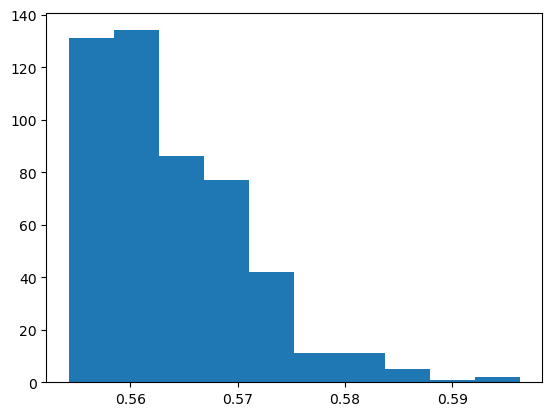

In [8]:
plt.hist(scores[1:], bins=10)

In [25]:
def plot_embeddings_2d(X):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    
    ax.scatter(X[11:, 0], X[11:, 1], marker=".", c=scores[11:], s=10, cmap="Spectral")
    ax.scatter(X[1:11, 0], X[1:11, 1], marker="s", c="green", s=50, label="Top 10")
    ax.scatter(X[0, 0], X[0, 1], marker="o", c="red", s=80, label="Query")

    for x, y in zip(X[1:11], X[1:11]):
        ax.plot([X[0, 0], x[0]], [X[0, 1], x[1]], "k--", alpha=0.5)

    fig.colorbar(plt.cm.ScalarMappable(cmap="Spectral"), ax=ax)
    plt.show()

def plot_embeddings_3d(X):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(X[11:, 0], X[11:, 1], marker=".", c=scores[11:], s=10)
    ax.scatter(X[1:11, 0],X[1:11, 1], marker="s", c="green", s=50, label="Top 10")
    ax.scatter(X[0, 0], X[0, 1], marker="o", c="red", s=80, label="Query")

    for x, y in zip(X[1:11], X[1:11]):
        ax.plot([X[0, 0], x[0]], [X[0, 1], x[1]], "k--", alpha=0.5)
    
    fig.colorbar(plt.cm.ScalarMappable(cmap="Spectral"), ax=ax)
    plt.show()

### UMAP

In [26]:
reducer = umap.UMAP(random_state=42, metric='cosine')
embeddings = reducer.fit_transform(vectors)

/home/fahmi/.mambaforge/envs/rumah/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


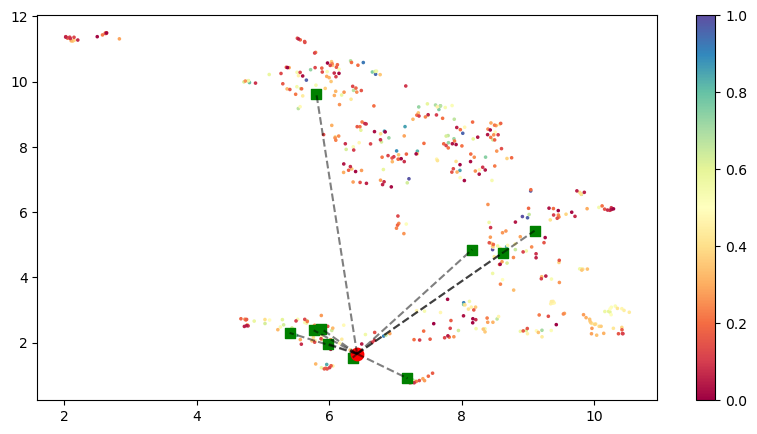

In [27]:
plot_embeddings_2d(embeddings)

In [28]:
reducer_3d = umap.UMAP(random_state=42, metric='cosine', n_components=3)
embeddings_3d = reducer_3d.fit_transform(vectors)

/home/fahmi/.mambaforge/envs/rumah/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


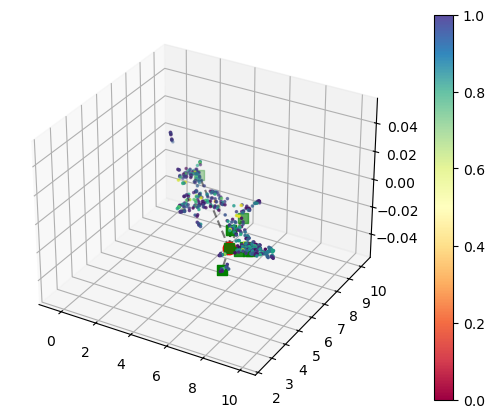

In [29]:
plot_embeddings_3d(embeddings_3d)

## TSNE

In [21]:
tsne = TSNE(n_components=2, random_state=0, perplexity=25, n_iter=1000, learning_rate=10)
embeddings = tsne.fit_transform(vectors)

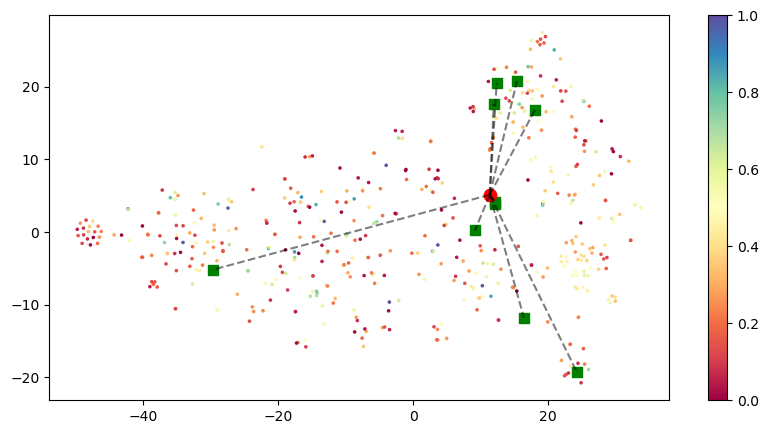

In [22]:
plot_embeddings_2d(embeddings)

In [23]:
tsne_3d = TSNE(n_components=3, random_state=0, perplexity=25, n_iter=1000, learning_rate=10)
embeddings_3d = tsne_3d.fit_transform(vectors)

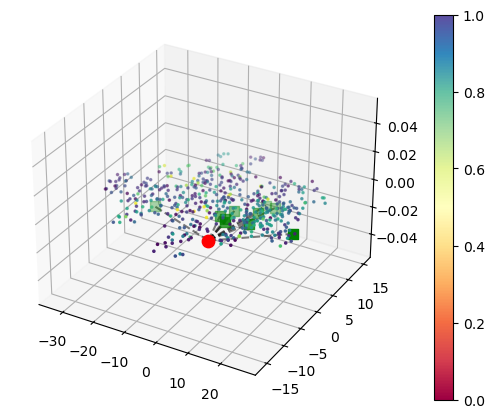

In [24]:
plot_embeddings_3d(embeddings_3d)